# Machine Learning Prototype

The idea is that we're going to create several different models and compare performance. The statsmodel api returns a lot of useful metrics to evaulate our model performance, so we'll use that to begin with. We'll build up a simple intuitive, baseline model and progressively add more features to the model, as well as eventually testing with a new PCA matrix.

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from ml_metrics import rmse
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices
from sklearn.metrics import mean_squared_error
from math import sqrt

read in engineered data from previous notebook, 02 Exploratory Data Analysis. 

In [2]:
engineered_df = pd.read_csv("data/engineered_df.csv")
#engineered_df = engineered_df.sample(frac=.1, replace = False,random_state=42)
engineered_df.reset_index(inplace = True)
engineered_df.drop(columns = "index", inplace = True)
print(engineered_df.shape)
engineered_df.head()

(3102802, 41)


,stars,log_useful,readability grades Kincaid,readability grades ARI,readability grades Coleman-Liau,readability grades FleschReadingEase,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,...,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,neg,neu,pos,compound
0,5,0.000000,4.536078,4.443219,7.866651,75.998464,7.728105,28.143791,8.163978,1.555556,...,1.0,0.0,1.0,0.0,1.0,2.0,0.000,0.424,0.576,0.9896
1,1,0.000000,6.277000,7.428000,10.055498,72.323500,9.800000,28.500000,9.708204,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.288,0.605,0.107,-0.5965
2,1,0.693147,9.534535,11.336512,10.307928,64.998547,14.181395,44.755814,12.486833,5.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.495,0.409,0.096,-0.9124
3,5,0.693147,6.743571,8.380429,8.799828,77.883929,11.571429,40.357143,10.745967,4.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.000,0.711,0.289,0.9246
4,5,0.000000,2.084909,2.618824,5.523797,94.423075,6.532835,28.780221,7.472136,1.666667,...,10.0,0.0,3.0,1.0,1.0,1.0,0.042,0.604,0.355,0.9944


In [3]:
X,y = engineered_df.drop(columns = ["log_useful"]), engineered_df.log_useful
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
print(X_train.shape, X_test.shape)

(2171961, 40) (930841, 40)


### Initial Intuitive Baseline Model
Here we'll create and evaluate a baseline model with intuitive features. We'll use stars and number of characters in a review to predict the log usefulness of it. Remember we found from the previous notebook that lower rated reviews tend to be more useful, as well as longer reviews being more useful. We made sense of this by noticing that the more stars the user gave the restaurant business, the shorter their review was because when people are pleased they're much more likely to leave a generic positive comment and not necessilarly comment on exactly what it was that they liked. On the flip side, lower rated reviews tend to be longer because when someone doesn't have a positive experience, if they're going to leave a review they're almost certainly going to say exactly what it was that made their experience negative so that those reading their review can understand exactly where their sentiment is coming from.

#### Standardize the Data for Linear Regression

Incase you're curious as to why we do this, here is a succint explanation
https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia

"In regression, it is often recommended to center the variables so that the predictors have mean 0. This makes it so the intercept term is interpreted as the expected value of 𝑌𝑖 when the predictor values are set to their means. Otherwise, the intercept is interpreted as the expected value of 𝑌𝑖 when the predictors are set to 0, which may not be a realistic or interpretable situation (e.g. what if the predictors were height and weight?). Another practical reason for scaling in regression is when one variable has a very large scale, e.g. if you were using population size of a country as a predictor. In that case, the regression coefficients may be on a very small order of magnitude (e.g. 10−6) which can be a little annoying when you're reading computer output, so you may convert the variable to, for example, population size in millions. The convention that you standardize predictions primarily exists so that the units of the regression coefficients are the same."

In this case, since we're going to use character count, and there is a high degree of variability here, the second reason in the above explanation is applicable. In general this just makes our results a lot more interprettable

In [4]:
X_standarized = preprocessing.scale(X_train)
X_standarized = pd.DataFrame(X_standarized, columns = X_train.columns)
y_tr = y_train.reset_index()
y_tr.drop(columns = "index", inplace = True)
standarized_df = pd.concat([X_standarized, y_tr], axis = 1)
standarized_df.head()

,stars,readability grades Kincaid,readability grades ARI,readability grades Coleman-Liau,readability grades FleschReadingEase,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,readability grades DaleChallIndex,...,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,neg,neu,pos,compound,log_useful
0,0.892817,-0.449738,-0.427919,-0.325546,0.462557,0.206763,-0.304333,0.579556,-0.287582,0.534675,...,-0.288457,-0.749758,-0.395863,-0.30604,-0.416640,-0.066081,0.151494,-0.083120,0.370517,0.000000
1,0.184818,-0.226277,-0.358710,0.095695,-0.150020,-0.711882,-1.902212,-0.701950,-1.419447,1.597028,...,-0.288457,-0.749758,-0.395863,-0.30604,-0.416640,-0.875993,-0.008315,0.474041,0.189345,0.000000
2,0.184818,0.134699,0.255624,0.208031,0.122489,-0.076397,-0.495653,-0.365650,-0.603198,1.906568,...,-0.288457,-0.749758,-0.395863,-0.30604,1.120619,-0.476906,1.422357,-0.921993,0.525614,3.526361
3,-1.939179,-0.747555,-0.437472,-0.294479,0.978613,0.313660,0.085017,0.691336,-0.004616,1.033313,...,-0.288457,-0.051087,1.476357,-0.30604,1.120619,3.678292,0.037344,-1.992495,-2.784726,0.000000
4,0.892817,0.321228,-0.399443,0.090854,-1.539567,1.196723,0.469364,0.869655,-0.240421,0.754943,...,-0.288457,0.647583,-0.395863,-0.30604,-0.416640,-0.875993,-2.877269,2.834153,0.560573,0.000000


In [5]:
def sm_Col_Generator(columns):
    cols = None
    for i, col in enumerate(columns):
        if i == 0:
            cols = col
        elif " " in col:
            cols = cols + " + " + 'Q("' + str(col) + '")'
        else:
            cols = cols + " + " + col
    return cols

In [6]:
features = sm_Col_Generator(["stars", "sentence info characters"])
smresults = smf.ols(formula = 'log_useful ~ ' + features, data=standarized_df).fit()
smresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_useful   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                 1.744e+05
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        21:40:24   Log-Likelihood:            -1.8378e+06
No. Observations:             2171961   AIC:                         3.676e+06
Df Residuals:                 2171958   BIC:                         3.676e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4089      0.000   1068.639      0.000       0.408       0.410
stars                            -0.0228      0.000    -58.581      0.000      -0.024      -0.022
Q("sentence info characters")     0.2210      0.000    568.735      0.000       0.220       0.222
==============================================================================
Omnibus:                   536969.555   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1389791.897
Skew:                           1.345   Prob(JB):                         0.00
Kurtosis:                       5.850   Cond. No.                         1.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we'll Look at Linear Regression with all of the original engineered features.

In [8]:
features = sm_Col_Generator(X.columns)
smresults = smf.ols(formula = 'log_useful ~ ' + features, data=standarized_df).fit()
smresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_useful   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                 1.311e+04
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        21:41:03   Log-Likelihood:            -1.7806e+06
No. Observations:             2171961   AIC:                         3.561e+06
Df Residuals:                 2171923   BIC:                         3.562e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.4089      0.000   1097.160      0.000       0.408       0.410
stars                                         -0.0236      0.001    -44.396      0.000      -0.025      -0.023
Q("readability grades Kincaid")               -0.0160      0.001    -23.224      0.000      -0.017      -0.015
Q("readability grades ARI")                 5.439e-05      0.001      0.053      0.958      -0.002       0.002
Q("readability grades Coleman-Liau")          -0.0350      0.001    -26.713      0.000      -0.038      -0.032
Q("readability grades FleschReadingEase")      0.0078      0.001     13.468      0.000       0.007       0.009
Q("readability grades GunningFogIndex")        0.0308      0.003     11.039      0.000       0.025       0.036
Q("readability grades LIX")                   -0.0183      0.002     -9.203      0.000      -0.022      -0.014
Q("readability grades SMOGIndex")             -0.0081      0.001     -6.143      0.000      -0.011      -0.006
Q("readability grades RIX")                    0.0199      0.001     14.791      0.000       0.017       0.023
Q("readability grades DaleChallIndex")         0.0023      0.001      3.819      0.000       0.001       0.003
Q("sentence info characters_per_word")         0.0507      0.001     34.038      0.000       0.048       0.054
Q("sentence info syll_per_word")               0.0058      0.001      8.371      0.000       0.004       0.007
Q("sentence info words_per_sentence")         -0.0197      0.001    -23.875      0.000      -0.021      -0.018
Q("sentence info sentences_per_paragraph")    -0.0856      0.001   -108.098      0.000      -0.087      -0.084
Q("sentence info type_token_ratio")           -0.0492      0.001    -61.492      0.000      -0.051      -0.048
Q("sentence info characters")                 -0.2199      0.017    -13.261      0.000      -0.252      -0.187
Q("sentence info syllables")                   0.2133      0.011     18.947      0.000       0.191       0.235
Q("sentence info words")                      -0.2828      0.011    -24.794      0.000      -0.305      -0.260
Q("sentence info wordtypes")                   0.4074      0.003    153.983      0.000       0.402       0.413
Q("sentence info sentences")                   0.0380      0.002     23.434      0.000       0.035       0.041
Q("sentence info paragraphs")                  0.0342      0.001     37.950      0.000       0.032       0.036
Q("sentence info long_words")                  0.0013      0.003      0.411      0.681      -0.005       0.008
Q("sentence info complex_words")              -0.0665      0.002    -33.156      0.000      -0.070      -0.063
Q("sentence info complex_words_dc")            0.0926      0.002     38.008      0.000

### Observations
R-squared: .138 vs .183 - Not bad for just two features. This means that about 13.8% and 18.3% of the variance in log useful votes can be explained by the features in our two models, respectively.


F-statistic: 174,400 and 13,110, respectively. Similar to our R-squared coefficient but with a slightly modified denominator,  we can think of the F-statistic here as equal to variation in log useful votes explained by the two features in our first model, and all 37 features in our second. Since our value is very high, this means the numerator is much larger than the demoninator, i.e. the variation in log useful votes explained by the features is much larger than the variation in log useful votes not explained by the features, so basically our feature has a lot more significance than non-significance. The reason that it goes down in our second model is most likely because we have some very small t values for features, meaning that we have some features that are not statistically significant. 
Note most importantly that Prob (F-statistic) is 0, which is what allows us to give credence to the F-statistic in the first place. You can think of this as meaning if we set the coefficient for all the features to 0, meaning our model doesn't use features at all when predicting the log useful votes and only uses the bias (intercept), then our model would be just as good as it was when we did use these features for our predictions. So, since this 0 that means we are confident that our model would be a lot worse without these features. 

Coefficient for number of  stars is negative in both models: This reaffirms what we found in our EDA, meaning that there is a negative correlation between how useful a review is and the number of stars the user gives the restaurant. 

Sentence Info Wordtypes Coefficient is huge: Again as we found in our EDA, the number of wordtypes is very indictive and has a very positive correlation with how useful a review is.

A skew of 1.345 and 1.257 means that our target variable log useful votes is right skewed, which is another factor we found in our previous EDA notebook.


## Next Feature Matrix

Now, since PCA fundamentally captures the features that contain the most variance in them, it's important that the features with the most variance don't contain a lot of multicollinearity between eachother. In other words, If we're going to project the features which contain the most information, we better make sure that the information from each feature isn't overlapping with the other features we project. The number of characters and The number of words in a review may have a lot of variance between them and be useful predictors, but ultimately the information they have has a lot of overlap. VIF takes care of this for us. 

From Investopedia, "Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. Mathematically, the VIF for a regression model variable is equal to the ratio of the overall model variance to the variance of a model that includes only that single independent variable."

We'll now implement this and remove variables with a VIF > 100. In general, a VIF above 10 indicates high correlation and is cause for concern, however in order to be incredibly safe we'll go for a factor of 10x this amount.

In [9]:
features = sm_Col_Generator(X.columns)
y_sm, X_sm = dmatrices('log_useful ~ ' + features, standarized_df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
vif["feature"] = ["intercept"] +  X.columns.tolist()

/Users/jzmichal/opt/anaconda3/envs/yelpEnv/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [10]:
vif

,VIF Factor,feature
0,1.404350e+01,intercept
1,2.032165e+00,stars
2,inf,readability grades Kincaid
3,inf,readability grades ARI
4,1.232506e+01,readability grades Coleman-Liau
5,inf,readability grades FleschReadingEase
6,5.586585e+01,readability grades GunningFogIndex
7,2.832683e+01,readability grades LIX
8,1.266800e+01,readability grades SMOGIndex
9,1.298927e+01,readability grades RIX


In [11]:
X_vif = X_standarized.copy()
for index, row in vif.iterrows():
    if row['VIF Factor'] > 100:
        X_vif.drop(columns = row["feature"], inplace = True)
new_df = pd.concat([X_vif, y_tr], axis = 1)
new_df.head()

,stars,readability grades Coleman-Liau,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,readability grades DaleChallIndex,sentence info sentences_per_paragraph,sentence info type_token_ratio,sentence info wordtypes,...,word usage preposition,word usage nominalization,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,compound,log_useful
0,0.892817,-0.325546,0.206763,-0.304333,0.579556,-0.287582,0.534675,-0.042496,0.887165,-0.462797,...,-0.632598,0.304553,-0.254133,-0.288457,-0.749758,-0.395863,-0.30604,-0.416640,0.370517,0.000000
1,0.184818,0.095695,-0.711882,-1.902212,-0.701950,-1.419447,1.597028,-0.849011,0.904962,-1.067502,...,-0.898679,-0.583111,-0.926211,-0.288457,-0.749758,-0.395863,-0.30604,-0.416640,0.189345,0.000000
2,0.184818,0.208031,-0.076397,-0.495653,-0.365650,-0.603198,1.906568,-0.804205,-1.136675,1.390333,...,0.609111,0.304553,0.081906,-0.288457,-0.749758,-0.395863,-0.30604,1.120619,0.525614,3.526361
3,-1.939179,-0.294479,0.313660,0.085017,0.691336,-0.004616,1.033313,-0.311334,0.398808,-0.716383,...,-0.277824,1.192217,-0.590172,-0.288457,-0.051087,1.476357,-0.30604,1.120619,-2.784726,0.000000
4,0.892817,0.090854,1.196723,0.469364,0.869655,-0.240421,0.754943,-0.580173,1.376606,-1.047996,...,-0.809985,-0.583111,-0.590172,-0.288457,0.647583,-0.395863,-0.30604,-0.416640,0.560573,0.000000


In [12]:
features = sm_Col_Generator(X_vif.columns)
y_sm, X_sm = dmatrices('log_useful ~ ' + features, new_df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
vif["feature"] = ["intercept"] +  X_vif.columns.tolist()

In [13]:
vif

,VIF Factor,feature
0,1.000000,intercept
1,1.881521,stars
2,2.828960,readability grades Coleman-Liau
3,18.546069,readability grades GunningFogIndex
4,21.275005,readability grades LIX
5,6.517865,readability grades SMOGIndex
6,10.640748,readability grades RIX
7,2.371216,readability grades DaleChallIndex
8,4.321536,sentence info sentences_per_paragraph
9,4.033996,sentence info type_token_ratio


We were able to remove 9 features with high VIF values, most of which we saw were not statistically significant from our previous model. Now we can see how an updated linear regression model performs. 

In [14]:
smresults = smf.ols(formula = 'log_useful ~ ' + features, data=new_df).fit()
smresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_useful   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                 1.705e+04
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        21:53:50   Log-Likelihood:            -1.7838e+06
No. Observations:             2171961   AIC:                         3.568e+06
Df Residuals:                 2171932   BIC:                         3.568e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.4089      0.000   1095.535      0.000       0.408       0.410
stars                                         -0.0238      0.001    -46.535      0.000      -0.025      -0.023
Q("readability grades Coleman-Liau")           0.0016      0.001      2.614      0.009       0.000       0.003
Q("readability grades GunningFogIndex")       -0.0375      0.002    -23.354      0.000      -0.041      -0.034
Q("readability grades LIX")                    0.0061      0.002      3.532      0.000       0.003       0.009
Q("readability grades SMOGIndex")              0.0125      0.001     13.124      0.000       0.011       0.014
Q("readability grades RIX")                    0.0031      0.001      2.537      0.011       0.001       0.005
Q("readability grades DaleChallIndex")         0.0143      0.001     24.828      0.000       0.013       0.015
Q("sentence info sentences_per_paragraph")    -0.0744      0.001    -95.876      0.000      -0.076      -0.073
Q("sentence info type_token_ratio")           -0.0351      0.001    -46.768      0.000      -0.037      -0.034
Q("sentence info wordtypes")                   0.3099      0.002    144.541      0.000       0.306       0.314
Q("sentence info sentences")                   0.0419      0.001     28.189      0.000       0.039       0.045
Q("sentence info paragraphs")                  0.0442      0.001     49.499      0.000       0.042       0.046
Q("sentence info long_words")                 -0.0111      0.002     -4.505      0.000      -0.016      -0.006
Q("sentence info complex_words")              -0.0286      0.002    -16.219      0.000      -0.032      -0.025
Q("sentence info complex_words_dc")            0.0089      0.002      4.282      0.000       0.005       0.013
Q("word usage tobeverb")                      -0.0511      0.001    -60.358      0.000      -0.053      -0.049
Q("word usage auxverb")                       -0.0084      0.001    -16.299      0.000      -0.009      -0.007
Q("word usage conjunction")                   -0.0211      0.001    -25.040      0.000      -0.023      -0.019
Q("word usage pronoun")                       -0.0620      0.001    -53.331      0.000      -0.064      -0.060
Q("word usage preposition")                   -0.0255      0.001    -20.404      0.000      -0.028      -0.023
Q("word usage nominalization")                -0.0054      0.000    -11.263      0.000      -0.006      -0.004
Q("sentence beginnings pronoun")               0.0318      0.001     39.325      0.000       0.030       0.033
Q("sentence beginnings interrogative")         0.0078      0.000     19.063      0.000       0.007       0.009
Q("sentence beginnings article")               0.0034      0.001      6.569      0.000

### Observations

R-squared: Only went down .003, which is very good considering we threw out about 25% of our features. 

F-statistic: Went back up, which makes sense because we removed variables that had high multicollinearity with other features.

## Deciding The Best Feature Matrix

In the previous notebook, we designed a feature matrix with over 35 NLP features and performed PCA on it. PCA showed us that the first two principal components accounted for just over 70% of the variance in the data. Additionally, we saw that the first principal component's coefficients were highest for our sentiment features, namely stars. The second principal component's coefficients were highest in relation to our category of "sentence info" NLP features, which includes number of characters. This goes hand in hand with why we chose our previous two baseline features to be these. 

Now, we can try and determine what additional features we can include to help the performance of our linear model. There's several metrics we can use to evaluate the performance of our model. We'll look at R-squared, Adjusted R-squared, AIC & BIC, and finally RMSE. I haven't gone into the meaning behind some of these terms before, so I'll give a quick overview of what they mean in the context of our model. 

AIC & BIC - These tools of information criterion are widely used in model selection. Roughly, these can be seen as measurements of the tradeoff between goodness of fit and number of variables for a statistical model. Without getting too mathy, we can give the formula for each and a brief description of what's going on

$BIC = \log(n)*k - 2\log(L)$

$AIC = 2*k - 2\log(L)$

where k is the number of features/columns, and n is the number of samples/rows we're using. L is essentially our measure of goodness of fit, so we want this to be high. Our first term in the BIC formula scales with the number of data points and features, while AIC scales with the just the number of features. Since L is a measure of the goodness of fit of our model, obviously we want the second term in both equations to be as higher as possible, which means that we'd like both AIC and BIC to be as low as possible. 

Adjusted R-squared: Similar to r-squared, this takes into account the number of features used to predict by the model. The adjusted r-squared increase only if the new term improves the model more than what would be expected by chance. In contrast, this value decreases when a feature improves the model by less than expected chance, meaning that if we just added a new feature and the adjusted r-squared went down, then this feature doesn't improve the model by a sufficient amount.


In [15]:
pca_cols = []
for i in range(20):
    pca_cols.append("PCA_{}".format(i))
X_tr_sub = X_train.copy()
for col in X_train.columns:
    if col not in vif.feature.tolist():
        X_tr_sub.drop(columns=col, inplace = True)
X_tr_sub.head()

,stars,readability grades Coleman-Liau,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,readability grades DaleChallIndex,sentence info sentences_per_paragraph,sentence info type_token_ratio,sentence info wordtypes,...,word usage pronoun,word usage preposition,word usage nominalization,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,compound
986754,5,5.482050,9.523019,25.694340,9.480741,1.600000,8.929052,5.000000,0.886792,47.0,...,6.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.8517
1134151,4,6.391075,5.822222,9.000000,6.872983,0.000000,10.223456,2.000000,0.888889,16.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7579
510212,4,6.633493,8.382297,23.695469,7.557327,1.153846,10.600608,2.166667,0.648402,142.0,...,16.0,17.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.9320
1346834,1,5.549091,9.953659,29.762195,9.708204,2.000000,9.536607,4.000000,0.829268,34.0,...,4.0,7.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,-0.7819
1471811,5,6.380629,13.511111,33.777778,10.071068,1.666667,9.197433,3.000000,0.944444,17.0,...,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.9501


In [16]:
r2_list, r2_adj_list, aic_list, bic_list, rmse_list_train, rmse_list_test = [0]*20,[0]*20,[0]*20,[0]*20,[0]*20,[0]*20
kf = KFold(n_splits=6, random_state = 13)
#6-Fold Cross-Validation with the training set
for train_index, val_index in kf.split(X_tr_sub, y_train):
    
    X_tr, X_val = X_tr_sub.iloc[train_index], X_tr_sub.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    X_tr = preprocessing.scale(X_tr)
    X_val = preprocessing.scale(X_val)
    rmse_train_total = rmse_test_total = 0
    for i in range(20):
        
        num_cols = i+1
        
        #calculate PCA transformation on training folds
        pca = PCA(n_components=num_cols)
        
        #apply PCA transform to training fold data
        X_tr_pca = pca.fit_transform(X_tr)
        X_tr_pca = pd.DataFrame(X_tr_pca, columns = pca_cols[:num_cols])
        #train model on training fold data
        sk_OLS = LinearRegression()
        sk_OLS.fit(X_tr_pca, y_tr)
        
        #apply PCA transformation to validation fold data
        X_val_pca = pca.transform(X_val)        
        X_val_pca = pd.DataFrame(X_val_pca, columns = pca_cols[:num_cols])
        
        #apply model to training and validation data and calculate loss
        y_hat_tr = sk_OLS.predict(X_tr_pca)
        y_hat_val = sk_OLS.predict(X_val_pca)

        X_tr_pca['log_useful'] = y_train
        features = sm_Col_Generator(pca_cols[:num_cols])
        formula = 'log_useful ~ ' + features
        sm_OLS = smf.ols(formula, data=X_tr_pca).fit()
        aic_list[i]+= sm_OLS.aic
        bic_list[i]+= sm_OLS.bic
        r2_list[i]+=sm_OLS.rsquared
        r2_adj_list[i]+= sm_OLS.rsquared_adj
        rmse_list_train[i]+= rmse(actual = y_tr, predicted = y_hat_tr)
        rmse_list_test[i]+= rmse(actual = y_val, predicted = y_hat_val)

/Users/jzmichal/opt/anaconda3/envs/yelpEnv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


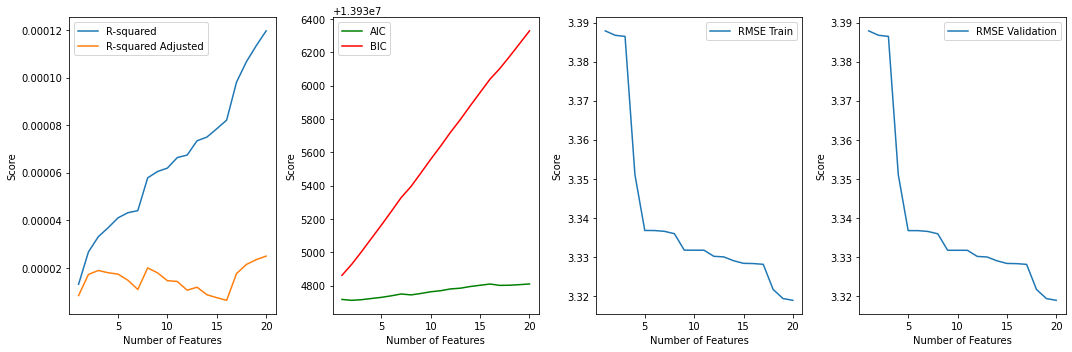

In [17]:
f, ax = plt.subplots(1,4, figsize = (15,5))
num_features = np.arange(1,21)
plt.subplot(141)
plt.plot(num_features, r2_list, label = "R-squared")
plt.plot(num_features, r2_adj_list, label = "R-squared Adjusted")
plt.legend(loc='best')
plt.xlabel('Number of Features')
plt.ylabel("Score")

plt.subplot(142)
plt.plot(num_features, aic_list, label = "AIC", color = "green")
plt.plot(num_features, bic_list, label = "BIC", color = "red")
plt.legend(loc='best')
plt.xlabel('Number of Features')
plt.ylabel("Score")

plt.subplot(143)
plt.plot(num_features, rmse_list_train, label = "RMSE Train")
plt.xlabel('Number of Features')
plt.ylabel("Score")
plt.legend(loc='best')

plt.subplot(144)
plt.plot(num_features, rmse_list_test, label = "RMSE Validation")
plt.xlabel('Number of Features')
plt.ylabel("Score")
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## Observations

The R-squared Continously goes up, although this is expected as adding additional features cannot have a negative effect. However, the adjusted R-squared fluctuates and  appears to go back up when we get just past 15 features, which coincides with the RMSE train and validation error. 

The RMSE drastically decreases as we increase features up until 5, where it appears to bottom out until we hit 17 features where it once again decreases. Note that these two look so similar since the amount of samples is so large. When you look at the difference in each iteration of the cross validation, you see that there is a noticable difference. AIC and BIC behave as expected.



3 Matrices:

1) Original Feature Matrix

2) Feature Matrix with VIF selected features

3) PCA Matrix from VIF matrix

### Random Forest Regression

Now, we'll move onto a more advanced, non-linear tree based form of regression. Since random forest has many hyperparameters, we'll use grid search to find the optimal number of hyperparameters for each model. Below is a brief description of the meaning behind each parameter

n_estimators - Number of trees in random forest

max_depth - Maximum number of levels in tree

max_features - Number of features to consider at every split

min_samples_split - Minimum number of samples required to split a node

min_samples_leaf - Minimum number of samples to allow in a leaf node

bootstrap - Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree

In [18]:
#1 - X_train
#2 - X_vif
#3 - X_pca
pca = PCA(n_components=num_cols)
X_pca = pca.fit_transform(X_standarized)
X_pca = pd.DataFrame(X_pca, columns = pca_cols)
n_estimators = [10,50,100, 200]
max_features = ['auto', 'sqrt']
max_depth = [5,10,15, None]
min_samples_split = [5,10,15]
min_samples_leaf = [4,8]
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf, 
              'min_samples_split': min_samples_split, 'bootstrap': bootstrap, 'max_features': max_features, 
              'max_depth': max_depth}

### Hyperparameter tuning
Since it takes a substantial amount of time to train and tune the hyperparameters, we'll subsample our data. Then once we find the best hyperparameters, we can train our model on all of the data and compare its performance on the test set with our simpler linear model. 

In [19]:
y_tr = y_train.reset_index()
y_tr.drop(columns = "index", inplace = True)

X_tr_sub = X_train.sample(frac=.001, replace = False,random_state=42)
X_vif_sub = X_vif.sample(frac=.001, replace = False,random_state=42)
X_pca_sub = X_pca.sample(frac=.001, replace = False,random_state=42)

y_sub_tr= y_train.loc[X_tr_sub.index.tolist()].to_frame()
y_sub_vif= y_tr.loc[X_vif_sub.index.tolist()]
y_sub_pca= y_tr.loc[X_pca_sub.index.tolist()]

In [20]:
sub_matrices = [X_tr_sub, X_vif_sub, X_pca_sub]
training_labels = [y_sub_tr, y_sub_vif, y_sub_pca]
full_data = [(X_train, y_train), (X_vif, y_tr), (X_pca, y_tr)]
model_list = []
i = 0
for m, y in zip(sub_matrices, training_labels):
    rf = GridSearchCV(RandomForestRegressor(random_state=13), param_grid)
    rf.fit(m, y.values.ravel())
    new_model = RandomForestRegressor(**rf.best_params_)
    new_model.fit(full_data[i][0], full_data[i][1].values.ravel())
    model_list.append(new_model)
    i+=1

## Random Forest Feature Importances for each data matrix

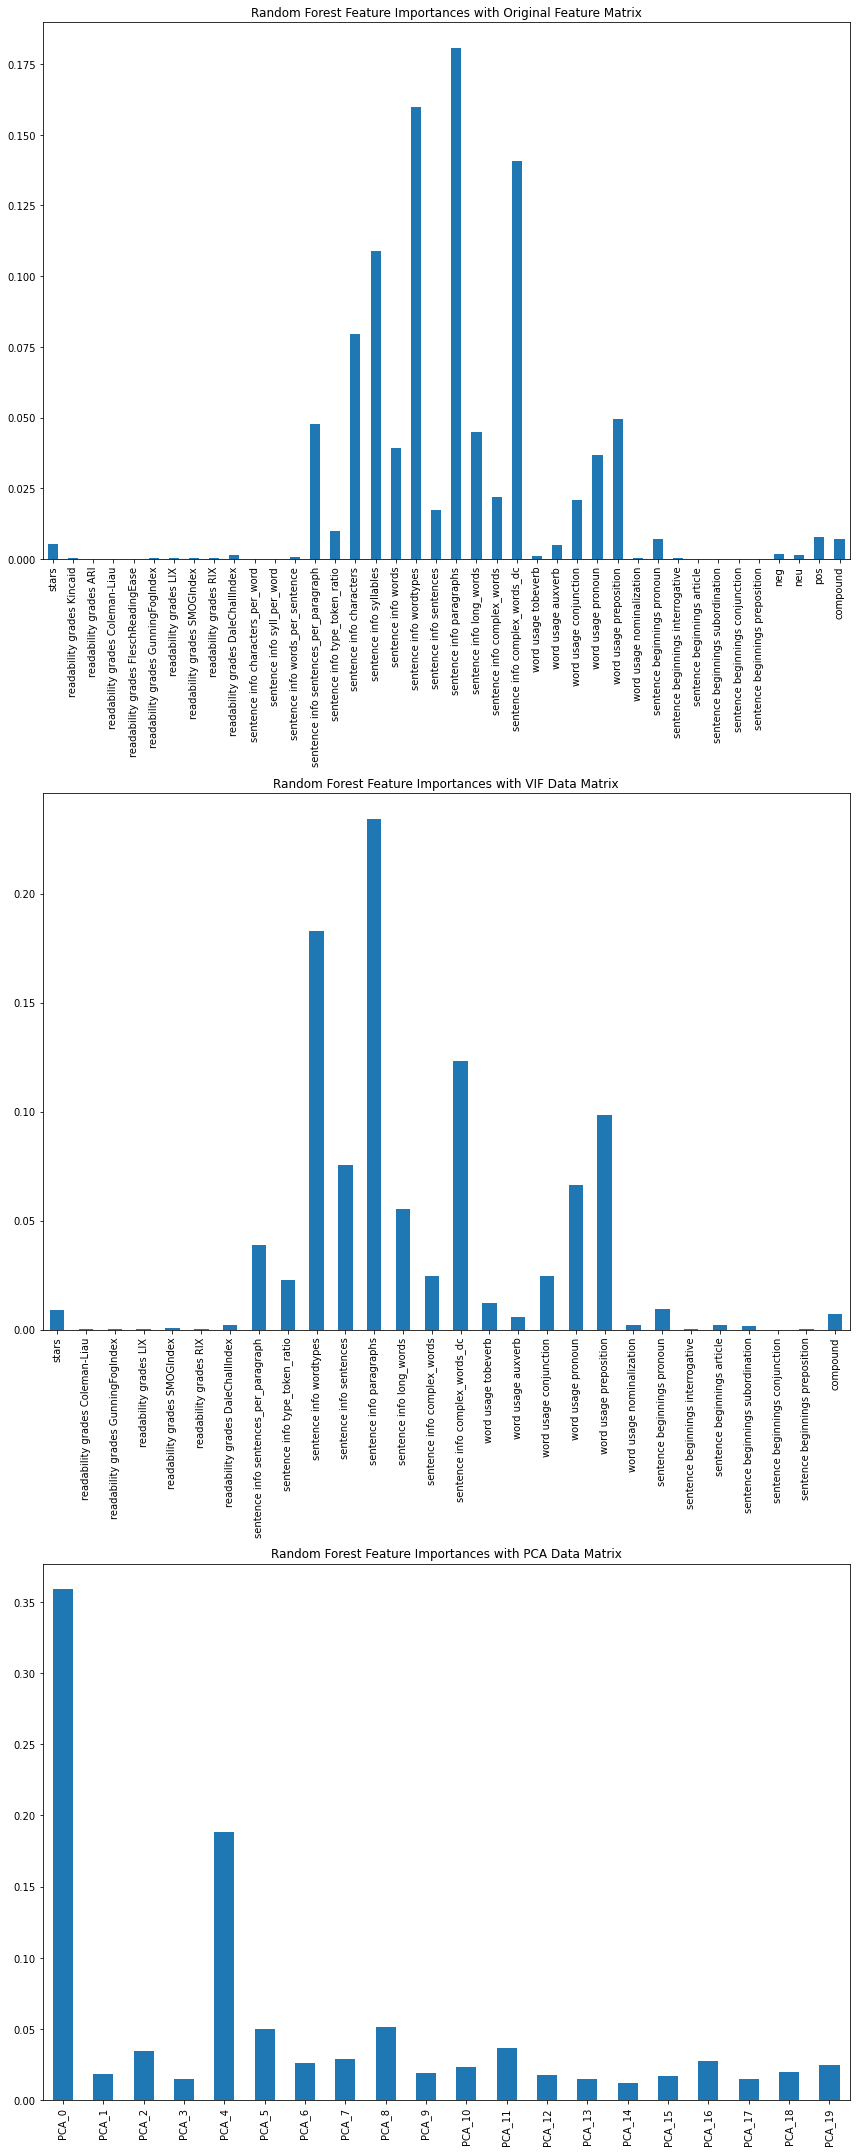

In [21]:
f, ax = plt.subplots(3,1,figsize = (12,30))

feature_significances = pd.Series(model_list[0].feature_importances_, index = X_train.columns)
feature_significances.plot(kind = "bar", ax = ax[0], 
                           title ="Random Forest Feature Importances with Original Feature Matrix")

feature_significances1 = pd.Series(model_list[1].feature_importances_, index = X_vif.columns)
feature_significances1.plot(kind = "bar", ax = ax[1], 
                            title ="Random Forest Feature Importances with VIF Data Matrix")

feature_significances1 = pd.Series(model_list[2].feature_importances_, index = X_pca.columns)
feature_significances1.plot(kind = "bar", ax = ax[2], 
                            title = "Random Forest Feature Importances with PCA Data Matrix")

plt.tight_layout()

As predicted in our EDA, the sentence info features seem to be the most important. Number of wordtypes, number of paragraphs, and number of complex words seem to be the three most pertinent features for both the original feature matrix and the VIF matrix. 

One might think that the from previous iteration over number of PCA features to include that the first five features would be the most important, however they seem to be spread about pretty evenly, aside from the PCA_0 and PCA_4. 

#### Final Observations 

In [22]:
lr_base = LinearRegression()
lr_vif = LinearRegression()
lr_pca = LinearRegression()
lr_base.fit(X_train, y_train)
lr_vif.fit(X_vif, y_tr)
lr_pca.fit(X_pca, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Prepare test matrix for VIF and PCA

In [23]:
X_test_stnd = preprocessing.scale(X_test)
X_test_stnd = pd.DataFrame(X_test_stnd, columns = X_test.columns)

X_test_pca = pca.transform(X_test_stnd)
X_test_vif = X_test_stnd.copy()
for col in X_test.columns:
    if col not in X_vif.columns:
        X_test_vif.drop(columns = col, inplace = True)
rf_base = model_list[0]
rf_vif = model_list[1]
rf_pca = model_list[2]

In [24]:
#fit linear regression to original matrix
lr_orgnl_train = lr_base.predict(X_train)
lr_orgnl_test = lr_base.predict(X_test)

#fit random forest with optimal parameters to original matrix
rf_orgnl_train = rf_base.predict(X_train)
rf_orgnl_test = rf_base.predict(X_test)

In [25]:
#fit linear regression to VIF matrix
lr_vif_train = lr_vif.predict(X_vif)
lr_vif_test = lr_vif.predict(X_test_vif)

#fit random forest with optimal parameters to VIF matrix
rf_vif_train = rf_vif.predict(X_vif)
rf_vif_test = rf_vif.predict(X_test_vif)

In [26]:
#fit linear regression to PCA matrix
lr_pca_train = lr_pca.predict(X_pca)
lr_pca_test = lr_pca.predict(X_test_pca)

#fit random forest with optimal parameters to PCA matrix
rf_pca_train = rf_pca.predict(X_pca)
rf_pca_test = rf_pca.predict(X_test_pca)

In [27]:
models = [(lr_orgnl_train, lr_orgnl_test, rf_orgnl_train, rf_orgnl_test), 
          (lr_vif_train, lr_vif_test, rf_vif_train, rf_vif_test), 
          (lr_pca_train, lr_pca_test, rf_pca_train, rf_pca_test)]

In [28]:
r2_train_scores = []
rmse_train_scores = []
rmse_test_scores = []
for lr_train, lr_test, rf_train, rf_test in models:   

    rmse_train_scores.append(sqrt(mean_squared_error(y_train, lr_train)))
    rmse_train_scores.append(sqrt(mean_squared_error(y_train, rf_train)))

    rmse_test_scores.append(sqrt(mean_squared_error(y_test, lr_test)))
    rmse_test_scores.append(sqrt(mean_squared_error(y_test, rf_test)))

    r2_train_scores.append(r2_score(y_train, lr_train))
    r2_train_scores.append(r2_score(y_train, rf_train))

In [29]:
labels = ["X_original", "X_vif", "X_pca"]

r2_train_lr = [r2_train_scores[0], r2_train_scores[2], r2_train_scores[4]]
r2_train_rf = [r2_train_scores[1], r2_train_scores[3], r2_train_scores[5]]

rmse_train_lr = [rmse_train_scores[0], rmse_train_scores[2], rmse_train_scores[4]]
rmse_train_rf = [rmse_train_scores[1], rmse_train_scores[3], rmse_train_scores[5]]

rmse_test_lr = [rmse_test_scores[0], rmse_test_scores[2], rmse_test_scores[4]]
rmse_test_rf = [rmse_test_scores[1], rmse_test_scores[3], rmse_test_scores[5]]

rmse_train_lr = [rmse_train_scores[0], rmse_train_scores[2], rmse_train_scores[4]]
rmse_train_rf = [rmse_train_scores[1], rmse_train_scores[3], rmse_train_scores[5]]

rmse_test_lr = [rmse_test_scores[0], rmse_test_scores[2], rmse_test_scores[4]]
rmse_test_rf = [rmse_test_scores[1], rmse_test_scores[3], rmse_test_scores[5]]

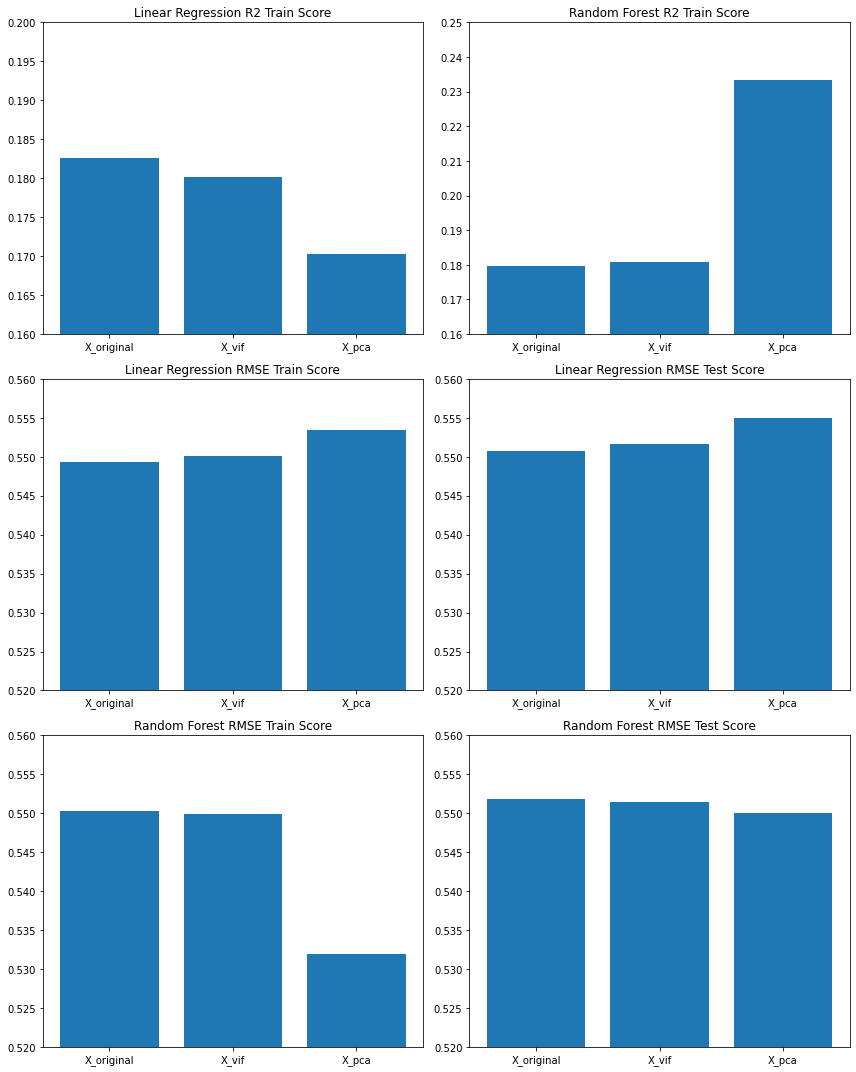

In [33]:
f, ax = plt.subplots(3,2, figsize = (12,15))

ax1 = plt.subplot(321)
ax1.bar(labels, r2_train_lr)
ax1.set_title("Linear Regression R2 Train Score")
ax1.set_ylim((.16,.2))

ax2 = plt.subplot(322)
ax2.bar(labels, r2_train_rf)
ax2.set_title("Random Forest R2 Train Score")
ax2.set_ylim((.16,.25))

ax3 = plt.subplot(323)
ax3.bar(labels, rmse_train_lr)
ax3.set_title("Linear Regression RMSE Train Score")
ax3.set_ylim((.52,.56))

ax4 = plt.subplot(324)
ax4.bar(labels, rmse_test_lr)
ax4.set_title("Linear Regression RMSE Test Score")
ax4.set_ylim((.52,.56))

ax5 = plt.subplot(325)
ax5.bar(labels, rmse_train_rf)
ax5.set_title("Random Forest RMSE Train Score")
ax5.set_ylim((.52,.56))

ax6 = plt.subplot(326)
ax6.bar(labels, rmse_test_rf)
ax6.set_title("Random Forest RMSE Test Score")
ax6.set_ylim((.52,.56))

plt.tight_layout()

## Observation

Random forest PCA appears to perform across the board better than other model/matrix combos. The R-squared for RF PCA is the clear winner, with a value nearing .24, where every other combination struggles to top .185. Additionally, the RMSE for RF + PCA beats out any other combination for both the training and test splits. 

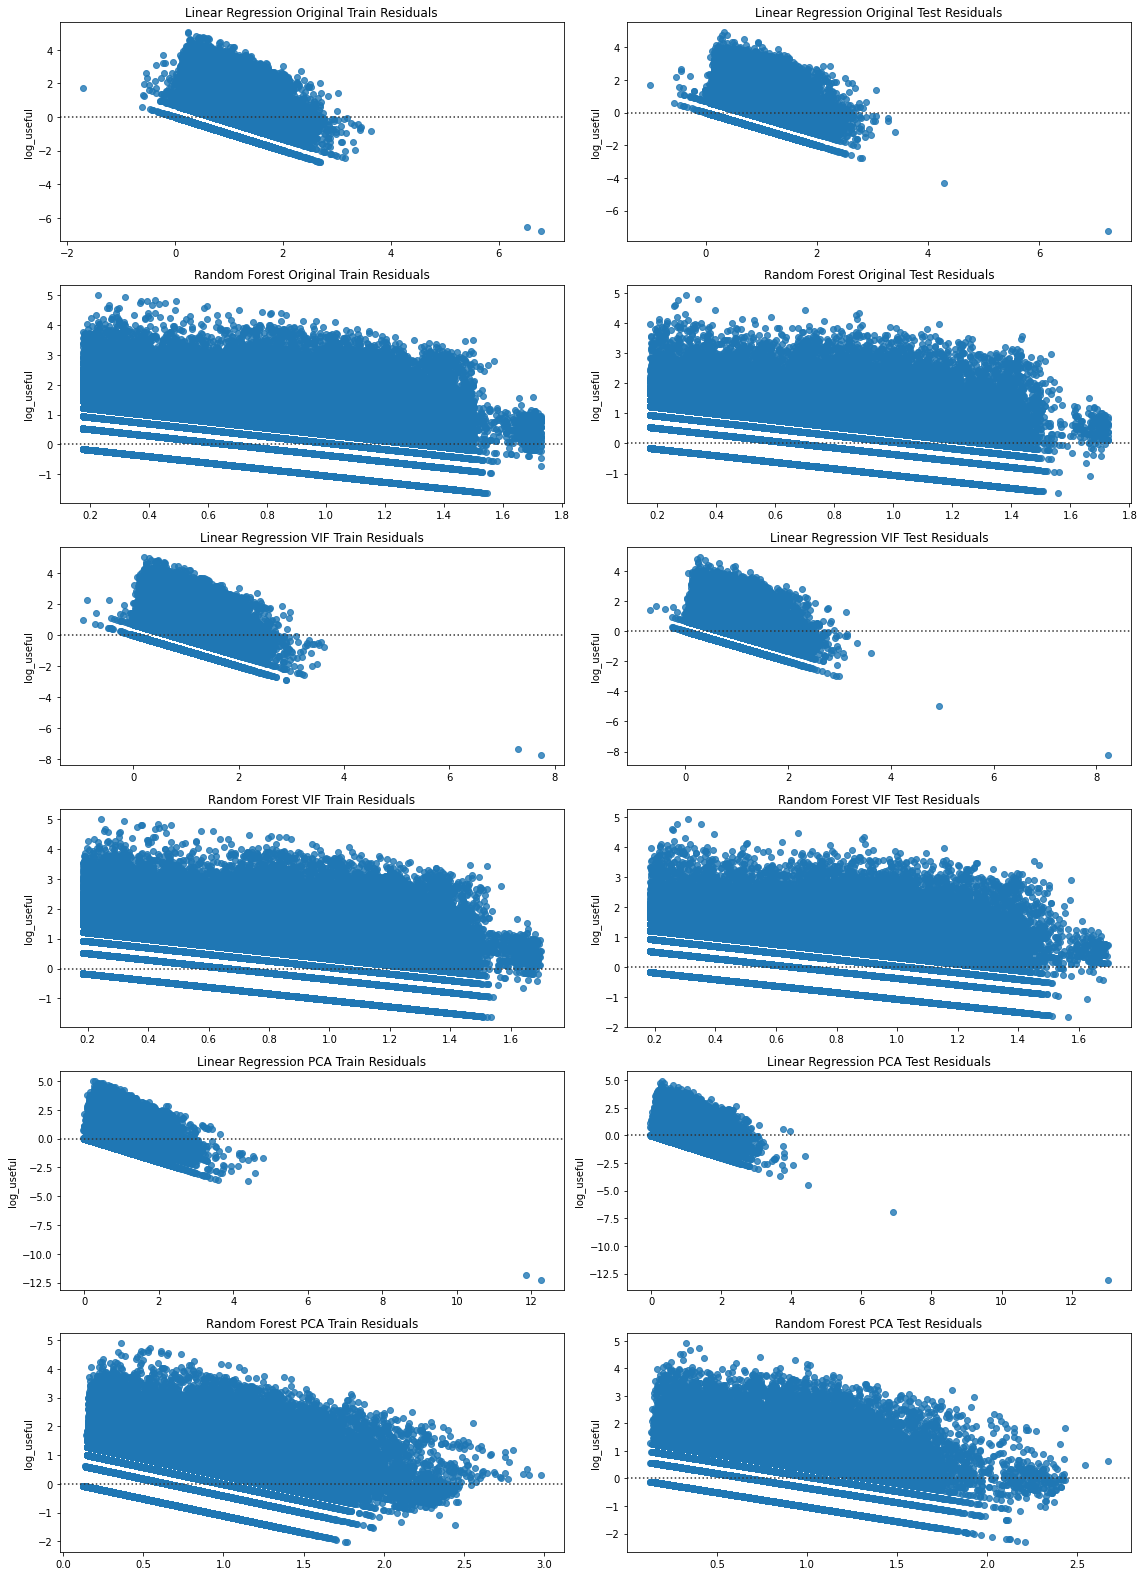

In [36]:
f, ax = plt.subplots(6,2, figsize = (16,22))

sns.residplot(x = lr_orgnl_train, y = y_train, ax = ax[0,0]).set_title("Linear Regression Original Train Residuals")
sns.residplot(x = lr_orgnl_test, y = y_test, ax = ax[0,1]).set_title("Linear Regression Original Test Residuals")

sns.residplot(x = rf_orgnl_train, y = y_train, ax = ax[1,0]).set_title("Random Forest Original Train Residuals")
sns.residplot(x = rf_orgnl_test, y = y_test, ax = ax[1,1]).set_title("Random Forest Original Test Residuals")

sns.residplot(x = lr_vif_train, y = y_train, ax = ax[2,0]).set_title("Linear Regression VIF Train Residuals")
sns.residplot(x = lr_vif_test, y = y_test, ax = ax[2,1]).set_title("Linear Regression VIF Test Residuals")

sns.residplot(x = rf_vif_train, y = y_train, ax = ax[3,0]).set_title("Random Forest VIF Train Residuals")
sns.residplot(x = rf_vif_test, y = y_test, ax = ax[3,1]).set_title("Random Forest VIF Test Residuals")

sns.residplot(x = lr_pca_train, y = y_train, ax = ax[4,0]).set_title("Linear Regression PCA Train Residuals")
sns.residplot(x = lr_pca_test, y = y_test, ax = ax[4,1]).set_title("Linear Regression PCA Test Residuals")

sns.residplot(x = rf_pca_train, y = y_train, ax = ax[5,0]).set_title("Random Forest PCA Train Residuals")
sns.residplot(x = rf_pca_test, y = y_test, ax = ax[5,1]).set_title("Random Forest PCA Test Residuals")

plt.tight_layout()

### Observations

As is evident, the linear regression models have several outliers and a much larger spread among the residual values, since the linear regression residual x-axis is at least 4x the size of the RF residual x-axis in each case. 

The next thing that sticks out is that each plot demonstrates a negative correlation between residual value and log_useful, meaning that as log_useful goes up, the residual goes down. So most of our reviews that end up having 0 log_useful votes, we over-estimate the number of votes that they'll receive. For more useful reviews, we tend to give better estimates. 

# Final Notes

The most important thing to note is that as we progressed in our notebook and experimented with different methods, the model became better. First, we tested out linear regression to create a baseline model, by which we figured out which features were important for our model, eventually moving on to remove features with high collinearity to prepare for PCA. 

With PCA, we cut the number of features we had in half, and found that our more advanced random forest model proved to be the best. We were able to achieve a R-squared value of approximately .24.